In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Elsevier XML Caption Extractor
- Extract Figure/Table captions from multiple XML files
- Output as CSV
- Uses lxml + XPath(local-name())
- Includes logging + tqdm progress

Usage:
python extract_captions.py --xml_dir ./xmls --output captions.csv
"""

import os
import argparse
import logging
from tqdm import tqdm
import csv
from lxml import etree


# -----------------------------------------------------
# Logging
# -----------------------------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s"
)


# -----------------------------------------------------
# Clean text helper
# -----------------------------------------------------
def clean_text(s: str) -> str:
    if not s:
        return ""
    s = s.replace("\n", " ").replace("\t", " ")
    s = " ".join(s.split())
    return s.strip()


# -----------------------------------------------------
# Extract captions from one XML file
# -----------------------------------------------------
def extract_captions_from_file(xml_path: str):
    try:
        tree = etree.parse(xml_path)
        root = tree.getroot()
    except Exception as e:
        logging.error(f"Failed to parse {xml_path}: {e}")
        return []

    records = []

    # ------------ Figures ------------
    fig_nodes = root.xpath("//*[local-name()='figure']")
    for node in fig_nodes:
        label = " ".join(node.xpath(".//*[local-name()='label']//text()"))
        cap = " ".join(node.xpath(".//*[local-name()='caption']//text()"))

        label = clean_text(label)
        cap = clean_text(cap)

        if cap:
            records.append({
                "file": os.path.basename(xml_path),
                "type": "figure",
                "label": label,
                "caption": cap,
            })

    # ------------ Tables ------------
    tbl_nodes = root.xpath("//*[local-name()='table']")
    for node in tbl_nodes:
        label = " ".join(node.xpath(".//*[local-name()='label']//text()"))
        cap = " ".join(node.xpath(".//*[local-name()='caption']//text()"))

        label = clean_text(label)
        cap = clean_text(cap)

        if cap:
            records.append({
                "file": os.path.basename(xml_path),
                "type": "table",
                "label": label,
                "caption": cap,
            })

    return records


# -----------------------------------------------------
# Process all files in a directory
# -----------------------------------------------------
def extract_from_dir(xml_dir: str):
    results = []

    # collect files
    files = []
    for root, dirs, fs in os.walk(xml_dir):
        for f in fs:
            if f.lower().endswith(".xml"):
                files.append(os.path.join(root, f))

    logging.info(f"Found {len(files)} XML files.")

    for fpath in tqdm(files, desc="Extracting captions"):
        recs = extract_captions_from_file(fpath)
        results.extend(recs)

    return results


# -----------------------------------------------------
# Save to CSV
# -----------------------------------------------------
def save_csv(rows, out_path: str):
    fieldnames = ["file", "type", "label", "caption"]

    with open(out_path, "w", encoding="utf-8-sig", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for r in rows:
            writer.writerow(r)

    logging.info(f"Saved {len(rows)} rows to {out_path}")


# -----------------------------------------------------
# CLI
# -----------------------------------------------------

rows = extract_from_dir("./xmls/")
save_csv(rows, "captions.csv")

2025-12-04 15:48:59,716 | INFO | Found 2826 XML files.
Extracting captions: 100%|██████████| 2826/2826 [01:39<00:00, 28.50it/s]
2025-12-04 15:50:39,255 | INFO | Saved 38969 rows to captions.csv


In [11]:
pd.DataFrame(rows)

,file,type,label,caption
0,S0001-8686(00)00040-3__FULL.xml,figure,Fig. 1,(a) Experimental setup for the synthesis of se...
1,S0001-8686(00)00040-3__FULL.xml,figure,Fig. 2,Typical temperature profile accompanying the g...
2,S0001-8686(00)00040-3__FULL.xml,figure,Fig. 3,Absorption spectra of CdSe nanocrystals dissol...
3,S0001-8686(00)00040-3__FULL.xml,figure,Fig. 4,Photoluminescence spectra of the same CdSe sam...
4,S0001-8686(00)00040-3__FULL.xml,figure,Fig. 5,Time-dependent spectral characteristics of exp...
...,...,...,...,...
38964,S0165-2370(22)00100-0__FULL.xml,table,Table 5,Kinetic parameters for PP.
38965,S0165-2370(22)00100-0__FULL.xml,table,Table 6,Comparison of the activation energies obtained...
38966,S0165-2370(22)00100-0__FULL.xml,table,Table 7,Rate constants (min −1 ) for polyolefins at 45...
38967,S0165-2370(22)00100-0__FULL.xml,table,Table 8,Comparison between the reported rate constants...


In [7]:
import pandas as pd 

CAPTIONS = pd.read_csv("./captions.csv")
SEARCJH_9706 = pd.read_csv("./9706_searched.csv")
SEARCJH_9706
CAPTIONS["pii"] = CAPTIONS["file"].apply(lambda x: x.split("_")[0])
# CAPTIONS에서 caption이 존재하는 PII 집합
pii_with_caption = set(CAPTIONS['pii'].unique())

# SEARCHJH 전체 PII 집합
pii_all = set(SEARCJH_9706['pii'].unique())

# caption이 하나도 없는 PII
pii_without_caption = pii_all - pii_with_caption

len(pii_without_caption)



7263

In [ ]:
len(pii_with_caption)

2444

In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
from lxml import etree
import logging
from tqdm import tqdm
import pandas as pd

XML_DIR = "./xmls"

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s"
)

# -----------------------------------------------------
# helper: clean text
# -----------------------------------------------------
def clean(s):
    if not s:
        return None
    s = s.replace("\n", " ").replace("\t", " ")
    s = " ".join(s.split())
    return s.strip()


# -----------------------------------------------------
# parse single xml
# -----------------------------------------------------
def parse_xml(path):
    try:
        tree = etree.parse(path)
        root = tree.getroot()
    except Exception as e:
        logging.error(f"parse error: {path} | {e}")
        return {
            "file": os.path.basename(path),
            "has_rawtext": False,
            "date_search_begin": None,
            "year_nav": None
        }

    # --------------------------
    # rawtext check
    # --------------------------
    rawtext_nodes = root.xpath("//*[local-name()='rawtext']")
    has_rawtext = len(rawtext_nodes) > 0

    # --------------------------
    # date-search-begin
    # --------------------------
    date_nodes = root.xpath("//*[local-name()='date-search-begin']//text()")
    date_val = clean(date_nodes[0]) if date_nodes else None

    # --------------------------
    # year-nav
    # --------------------------
    year_nodes = root.xpath("//*[local-name()='year-nav']//text()")
    year_val = clean(year_nodes[0]) if year_nodes else None

    return {
        "file": os.path.basename(path),
        "has_rawtext": has_rawtext,
        "date_search_begin": date_val,
        "year_nav": year_val
    }


# -----------------------------------------------------
# run over directory
# -----------------------------------------------------
def run(xml_dir):
    xml_files = [
        os.path.join(xml_dir, f)
        for f in os.listdir(xml_dir)
        if f.lower().endswith(".xml")
    ]

    logging.info(f"총 XML 파일: {len(xml_files)}")

    records = []

    for path in tqdm(xml_files, desc="Parsing XML"):
        rec = parse_xml(path)
        records.append(rec)

    return records


# -----------------------------------------------------
# main
# -----------------------------------------------------
records = run(XML_DIR)

# pandas dataframe
df = pd.DataFrame(records)

# save
df.to_csv("xml_metadata.csv", index=False, encoding="utf-8-sig")

# summary log
logging.info("=== Summary ===")
logging.info(f"Total files: {len(df)}")
logging.info(f"Has rawtext: {df['has_rawtext'].sum()}")
logging.info(f"No rawtext: {(~df['has_rawtext']).sum()}")

logging.info(f"Rows saved: xml_metadata.csv")


2025-12-04 16:07:09,334 | INFO | 총 XML 파일: 6118
Parsing XML:   0%|          | 0/6118 [00:00<?, ?it/s]

Parsing XML: 100%|██████████| 6118/6118 [04:13<00:00, 24.15it/s]
2025-12-04 16:11:22,732 | INFO | === Summary ===
2025-12-04 16:11:22,733 | INFO | Total files: 6118
2025-12-04 16:11:22,734 | INFO | Has rawtext: 393
2025-12-04 16:11:22,735 | INFO | No rawtext: 5725
2025-12-04 16:11:22,735 | INFO | Rows saved: xml_metadata.csv


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
from lxml import etree
import logging
from tqdm import tqdm
import pandas as pd
from multiprocessing import Pool, cpu_count


XML_DIR = "./xmls"  # XML 폴더 경로
N_WORKERS = max(1, cpu_count() - 1)  # 추천: 전체 CPU - 1

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s"
)


# -----------------------------------------------------
# helper: clean text
# -----------------------------------------------------
def clean(s):
    if not s:
        return None
    s = s.replace("\n", " ").replace("\t", " ")
    s = " ".join(s.split())
    return s.strip()


# -----------------------------------------------------
# parse single xml (must be top-level for multiprocessing)
# -----------------------------------------------------
def parse_xml(path):
    fname = os.path.basename(path)

    try:
        tree = etree.parse(path)
        root = tree.getroot()
    except Exception:
        # 파싱 실패 시 기본값 반환
        return {
            "file": fname,
            "has_rawtext": False,
            "date_search_begin": None,
            "year_nav": None
        }

    # --------------------------
    # rawtext 존재 검출
    # --------------------------
    rawtext_nodes = root.xpath("//*[local-name()='rawtext']")
    has_rawtext = len(rawtext_nodes) > 0

    # --------------------------
    # date-search-begin
    # --------------------------
    date_nodes = root.xpath("//*[local-name()='date-search-begin']//text()")
    date_val = clean(date_nodes[0]) if date_nodes else None

    # --------------------------
    # year-nav
    # --------------------------
    year_nodes = root.xpath("//*[local-name()='year-nav']//text()")
    year_val = clean(year_nodes[0]) if year_nodes else None

    return {
        "file": fname,
        "has_rawtext": has_rawtext,
        "date_search_begin": date_val,
        "year_nav": year_val
    }


# -----------------------------------------------------
# parallel run
# -----------------------------------------------------
def run_parallel(xml_dir):
    # 대상 XML 파일 리스트 수집
    xml_files = [
        os.path.join(xml_dir, f)
        for f in os.listdir(xml_dir)
        if f.lower().endswith(".xml")
    ]

    logging.info(f"총 XML 파일: {len(xml_files)}")
    logging.info(f"사용 CPU: {N_WORKERS}")

    records = []

    # 병렬 실행
    with Pool(N_WORKERS) as pool:
        for rec in tqdm(pool.imap_unordered(parse_xml, xml_files), total=len(xml_files)):
            records.append(rec)

    return records


# -----------------------------------------------------
# main
# -----------------------------------------------------

records = run_parallel(XML_DIR)

# pandas dataframe
df = pd.DataFrame(records)

# save
out_csv = "xml_metadata.csv"
df.to_csv(out_csv, index=False, encoding="utf-8-sig")

# summary
total = len(df)
with_raw = df["has_rawtext"].sum()
without_raw = total - with_raw

logging.info("=== Summary ===")
logging.info(f"Total files: {total}")
logging.info(f"Has rawtext: {with_raw}")
logging.info(f"No rawtext: {without_raw}")
logging.info(f"Rows saved: {out_csv}")


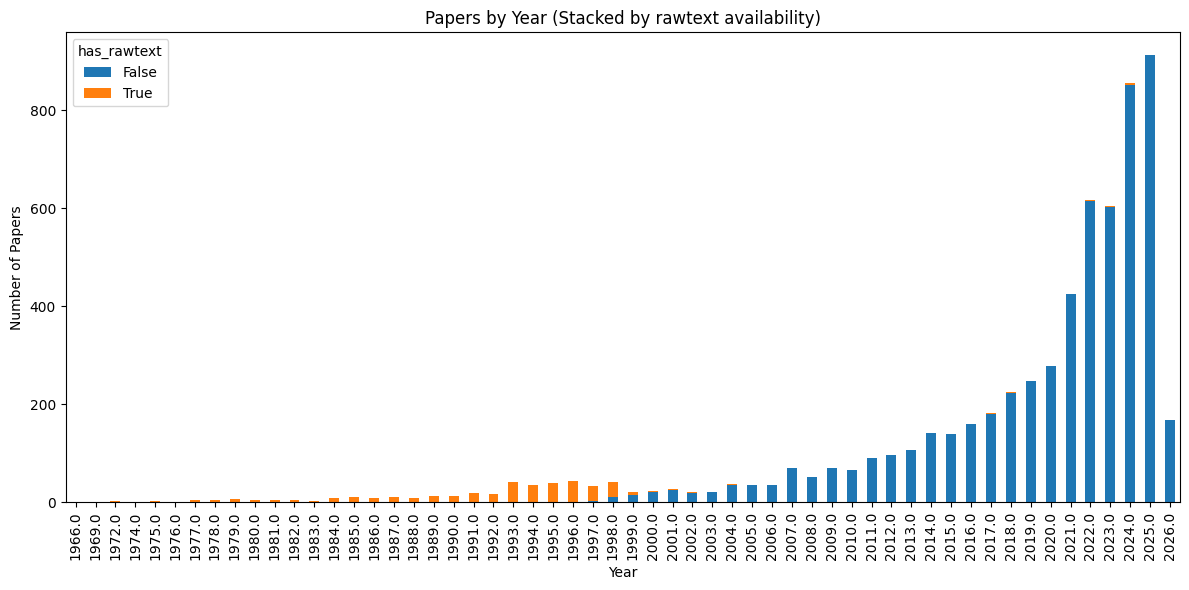

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("xml_metadata.csv")

# year_nav → 정수로 변환
df['year'] = pd.to_numeric(df['year_nav'], errors='coerce').dropna().astype(int)

pivot = df.pivot_table(
    index='year',
    columns='has_rawtext',
    aggfunc='size',
    fill_value=0
)

pivot.plot(kind='bar', stacked=True, figsize=(12,6))
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.title("Papers by Year (Stacked by rawtext availability)")
plt.tight_layout()
plt.show()



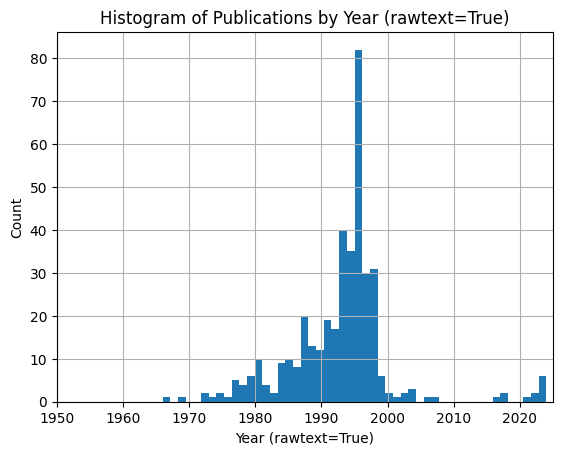

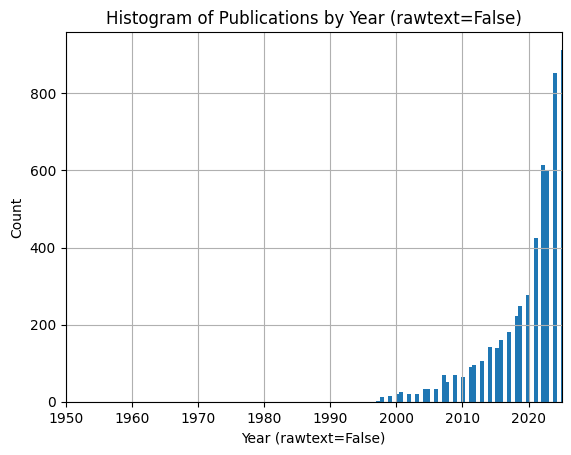

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("xml_metadata.csv")

df['year'] = pd.to_numeric(df['year_nav'], errors='coerce')

# rawtext True
df_true = df[df['has_rawtext'] == True]
plt.figure()
df_true['year'].dropna().hist(bins=50)
plt.xlabel("Year (rawtext=True)")
plt.ylabel("Count")
plt.title("Histogram of Publications by Year (rawtext=True)")
plt.xlim(1950, 2025)
plt.show()

# rawtext False
df_false = df[df['has_rawtext'] == False]
plt.figure()
df_false['year'].dropna().hist(bins=50)
plt.xlabel("Year (rawtext=False)")
plt.xlim(1950, 2025)
plt.ylabel("Count")
plt.title("Histogram of Publications by Year (rawtext=False)")
plt.show()


In [ ]:
import os
import pandas as pd
from lxml import etree
from tqdm import tqdm


XML_DIR = "./xmls"
META_CSV = "./xml_metadata.csv"


# ----------------------------------------------------
# caption 존재 여부 판단
# ----------------------------------------------------
def has_caption(path):
    try:
        tree = etree.parse(path)
        root = tree.getroot()
    except Exception:
        return False

    # figure caption
    fig_caps = root.xpath("//*[local-name()='figure']//*[local-name()='caption']")
    if len(fig_caps) > 0:
        return True

    # table caption
    table_caps = root.xpath("//*[local-name()='table']//*[local-name()='caption']")
    if len(table_caps) > 0:
        return True

    # no caption
    return False


# ----------------------------------------------------
# main
# ----------------------------------------------------
def main():

    # load metadata
    df = pd.read_csv(META_CSV)

    # 대상 = has_rawtext == False
    df_no = df[df["has_rawtext"] == False]

    print(f"총 파일( has_rawtext=False ): {len(df_no)}")

    results = []

    for fname in tqdm(df_no["file"], desc="Checking captions"):
        xml_path = os.path.join(XML_DIR, fname)
        cap = has_caption(xml_path)

        results.append({
            "file": fname,
            "has_caption": cap
        })

    df_cap = pd.DataFrame(results)

    # merge back
    df_merge = df_no.merge(df_cap, on="file", how="left")

    # save
    df_merge.to_csv("F.csv", index=False, encoding="utf-8-sig")

    # stats
    total = len(df_merge)
    yes = df_merge["has_caption"].sum()
    no = total - yes

    print("\n=== Summary ===")
    print(f"총 문서: {total}")
    print(f"caption 있는 문서: {yes}")
    print(f"caption 없는 문서: {no}")
    print(f"비율: {yes/total:.2%}")


if __name__ == "__main__":
    main()


총 파일( has_rawtext=False ): 5725


Checking captions: 100%|██████████| 5725/5725 [02:36<00:00, 36.65it/s]


=== Summary ===
총 문서: 5725
caption 있는 문서: 5695
caption 없는 문서: 30
비율: 99.48%
